In [114]:
import cv2
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from scipy.ndimage import zoom
from sklearn.cluster import KMeans
from skimage.measure import label, regionprops
import numpy as np
import math

In [115]:
cells_path = 'cl'
background_path = 'bg'

In [116]:
for filename in os.listdir(background_path):
    img=Image.open('bg/' + filename)
    rimg = img.resize((32,32))
    rimg.save('bg/' + filename)
for filename in os.listdir(cells_path):
    img=Image.open('cl/' + filename)
    rimg = img.resize((64,64))
    rimg.save('cl/' + filename)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

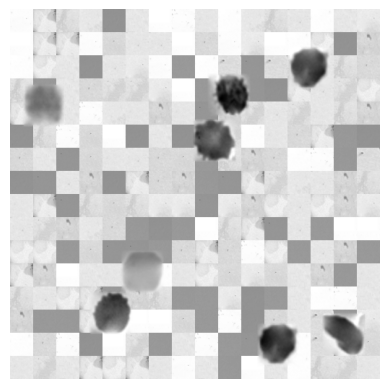

In [117]:
import cv2
import numpy as np
import random
import os
from glob import glob
import matplotlib.pyplot as plt

def bg_create():
    bg = np.zeros((512,512,3), dtype=np.uint8)
    patch = glob(os.path.join('bg/',"*.png"))
    for i in range(512//32):
        for j in range(512//32):
            p = cv2.imread(random.choice(patch),cv2.IMREAD_GRAYSCALE)
            p = cv2.cvtColor(p, cv2.COLOR_GRAY2BGR)
            bg[i*32:(i+1)*32,j*32:(j+1)*32] = p
    return bg
def cell_create(bg):
    cells = glob(os.path.join('cl/',"*.png"))
    cell = cv2.imread(random.choice(cells),cv2.IMREAD_GRAYSCALE)
    cell = cv2.cvtColor(cell, cv2.COLOR_GRAY2BGR)
    mask = 255 * np.ones(cell.shape, dtype=np.uint8)
    place = (random.randint(0, 512 - 64) + 64 // 2, random.randint(0, 512 - 64) + 64 // 2)
    img = cv2.seamlessClone(cell,bg,mask,place,cv2.NORMAL_CLONE)
    return img
def gauss(img):
    mean = 0
    stddev = 100
    noise_gauss = np.zeros(img.shape, np.uint8)
    cv2.randn(noise_gauss, mean, stddev)
    img = cv2.add(img,noise_gauss)
    return img
def const(img):
    img = cv2.add(img, 10)
    return img
def generate():
    while 1:
        img = bg_create()
        for i in range(random.randint(1,10)):
            img = cell_create(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gs = gauss(img)
        ct = const(img)
        yield img, gs, ct
gen = generate() 
img, gs, ct = next(gen)
plt.imshow(img, cmap = 'gray')
plt.axis('off')

In [118]:
def coarseness(img):
    M, N = img.shape
    img = np.float32(img)

    A0 = np.zeros((M,N))
    A1 = np.zeros((M,N))
    A2 = np.zeros((M,N))
    A3 = np.zeros((M,N))
    Sbest = np.zeros((M, N))
    E0h = np.zeros((M, N))
    E0v = np.zeros((M, N))
    E1h = np.zeros((M, N))
    E1v = np.zeros((M, N))
    E2h = np.zeros((M, N))
    E2v = np.zeros((M, N))
    E3h = np.zeros((M, N))
    E3v = np.zeros((M, N))
    
    for x in range(1, M):
        for y in range(1, N):
            A0[x,y] = (1/1)*(np.sum(np.sum(img[x-1:x+1,y-1:y+1])))
    for x in range(2, M - 2):
            for y in range(2, N - 2):
                 A1[x,y] = (1/2)*(np.sum(np.sum(img[x-1:x+1,y-1:y+1])))
    for x in range(4, M - 4):
            for y in range(4, N - 4):
                A2[x,y] = (1/4)*(np.sum(np.sum(img[x-1:x+1,y-1:y+1])))
    for x in range(8, M - 8):
            for y in range(8, N - 8):
                A3[x,y] = (1/8)*(np.sum(np.sum(img[x-1:x+1,y-1:y+1])))
    for x in range(1, M - 1):
        for y in range(1, N - 1):
            E0h[x,y] = A0[x+1,y]-A0[x-1,y]
            E0v[x,y] = A0[x,y+1]-A0[x,y-1]
    for x in range(2, M - 2):
            for y in range(2, N - 2):
                E1h[x,y] = A1[x+2,y]-A1[x-2,y]
                E1v[x,y] = A1[x,y+2]-A1[x,y-2]
    for x in range(4, M - 4):
            for y in range(4, N - 4):
                E2h[x,y] = A2[x+4,y]-A2[x-4,y]
                E2v[x,y] = A2[x,y+4]-A2[x,y-4]
    for x in range(8, M - 8):
            for y in range(8, N - 8):
                E3h[x,y] = A3[x+8,y]-A3[x-8,y]
                E3v[x,y] = A3[x,y+8]-A3[x,y-8]
    for i in range(0, M):
        for j in range(0, N):
            E = np.argmax(np.array([abs(E0h[i,j]), abs(E0v[i,j]), abs(E1h[i,j]), abs(E1v[i,j]), abs(E2h[i,j]), abs(E2v[i,j]), abs(E3h[i,j]), abs(E3v[i,j])]))
            k=math.floor((E+1)/2)
            Sbest[i, j] = 2 ** k

    return np.sum(np.sum(Sbest))/(M*N)

In [119]:
cv2.imwrite("img.png", img)

True

In [120]:
def contrast(img):
    img = np.float32(img)
    x = np.copy(img)
    M4 = np.mean((x - np.mean(x)) ** 4)
    delta2 = np.var(x)
    alfa4 = M4/(delta2 ** 2)
    delta = np.std(x)
    return delta/(alfa4 ** (1/4))

In [121]:
def directionality(img):
    Gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(Gx**2 + Gy**2)
    gradient_direction = np.arctan2(Gy, Gx) * 180 / np.pi
    num_bins = 16 
    histogram, _ = np.histogram(gradient_direction, bins=num_bins, range=(-90, 90), weights=gradient_magnitude)
    histogram = histogram / np.sum(histogram)
    Fdir = np.sum(histogram**2)
    return Fdir

In [122]:
cor =coarseness(img)
con = contrast(img)
direct = directionality(img)
print(f"зернистость {cor}")
print(f"контрастность {con}")
print(f"направленность {direct}")

зернистость 5.578815460205078
контрастность 28.78436279296875
направленность 0.10045095098472086


 3 кластера


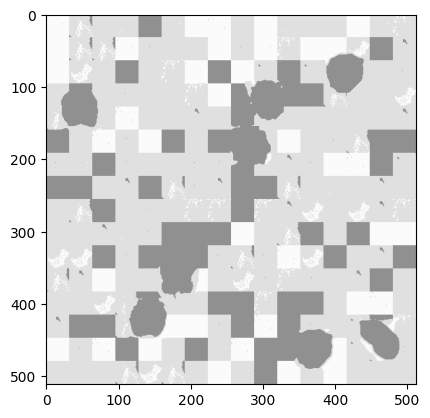

In [123]:
from sklearn.cluster import KMeans
img = cv2.imread("img.png")
pixel_values = img.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
kmeans = KMeans(3, random_state=42)
kmeans.fit(pixel_values)
labels = kmeans.labels_
centers = kmeans.cluster_centers_
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(img.shape)
print(" 3 кластера")
plt.imshow(segmented_image)

In [124]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
pixels = img.reshape(-1, 3)[::10]
labels_sampled = labels.reshape(-1)[::10]
mt = metrics.silhouette_score(pixels, labels_sampled)
print(mt)

0.6621847461987075


In [125]:
from skimage.measure import label, regionprops
from skimage import measure
lb,image = cv2.connectedComponents((labels > 0).astype(np.uint8))
regions = measure.regionprops(image)
areas = [r.area for r in regions if r.area > 10]
print(f"объектов {lb}")
print(f"средняя площадь {np.mean(areas) if areas else 0}")

объектов 4843
средняя площадь 47.96620099143758
